In [564]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [565]:
def wendland_kernel(x, y):
    return np.max(1 - np.abs(x - y), 0)


# def f(x, alpha=0.6):
#     return np.pow(x, alpha)


def f(x):
    return x**2 * np.sin(32 * np.pi * x / (x + 1))

In [566]:
class BetaGreedySearch:
    def __init__(self, input_x, input_y, kernel=None, f=None, beta=0):
        self.points_set = input_x
        self.observations = input_y
        self.f = f
        self.kernel = kernel
        self.beta = beta

        self.n = len(input_y)
        self.kernel_operator = np.array([lambda a, b=b: kernel(a, b) for b in input_x])
        self.kernel_matrix = np.zeros((self.n, self.n))
        for i in range(self.n):
            for j in range(self.n):
                self.kernel_matrix[i, j] = self.kernel(
                    self.points_set[i], self.points_set[j]
                )

        self.observations_vector = np.array(input_y)

    def power_func(self, x):
        kernel_vector = np.array([op(a=x) for op in self.kernel_operator])

        L = np.linalg.cholesky(self.kernel_matrix)
        u = np.linalg.solve(L, kernel_vector)
        p2 = self.kernel(x, x) - u.dot(u)
        return np.sqrt(p2)

    def interpolation_func(self, x, index=None):
        kernel_vector = np.array([op(a=x) for op in self.kernel_operator])

        if index is not None:
            kernel_vector = kernel_vector[index]
            observations_vector = self.observations_vector[index]
            kernel_matrix = self.kernel_matrix[np.ix_(index, index)]
        else:
            observations_vector = self.observations_vector
            kernel_matrix = self.kernel_matrix

        L = np.linalg.cholesky(kernel_matrix)
        u = np.linalg.solve(L, kernel_vector)
        v = np.linalg.solve(L, observations_vector)
        sn = u.dot(v)
        return sn

    def beta_greedy_obj(self, x):
        return (
            -1
            * np.power(np.abs(self.f(x) - self.interpolation_func(x)), self.beta)
            * np.power(self.power_func(x), 1 - self.beta)
        )

    def forward(self, obj_func=None):
        starting_points = np.linspace(0, 1, 50)

        with ThreadPoolExecutor() as executor:
            futures = [
                executor.submit(
                    minimize,
                    obj_func,
                    x_0,
                    method="nelder-mead",
                    options={"xatol": 1e-8, "disp": False},
                    bounds=[(0, 1)],
                )
                for x_0 in starting_points
            ]

            best_x = None
            best_fun = float("inf")

            for future in futures:
                res = future.result()
                x, fun = res.x, res.fun
                if fun < best_fun:
                    best_fun = fun
                    best_x = x

        # xgrid = np.linspace(0, 1, 1000)
        # plt.plot(
        #     xgrid,
        #     [obj_func(x) for x in xgrid],
        #     color="black",
        # )
        # plt.axvline(x=best_x, color="red", linestyle="--")
        # plt.show()

        return (best_x, best_fun)

    def update(self, x, y):
        new_col = np.array([op(a=x) for op in self.kernel_operator])
        new_row = np.append(np.transpose(new_col), self.kernel(x, x))

        self.kernel_matrix = np.vstack(
            (np.column_stack((self.kernel_matrix, new_col)), new_row)
        )

        self.points_set = np.append(self.points_set, x)
        self.observations_vector = np.append(self.observations_vector, y)

        self.kernel_operator = np.append(
            self.kernel_operator, lambda a, b=x: self.kernel(a, b)
        )

        self.n = self.n + 1

In [567]:
n = 10
# input_x = np.sort(np.random.uniform(0, 1, n))
input_x = np.linspace(0, 1, 10)
input_y = np.array([f(x) for x in input_x])

beta = 0

beta_greedy_search = BetaGreedySearch(input_x, input_y, wendland_kernel, f, beta)

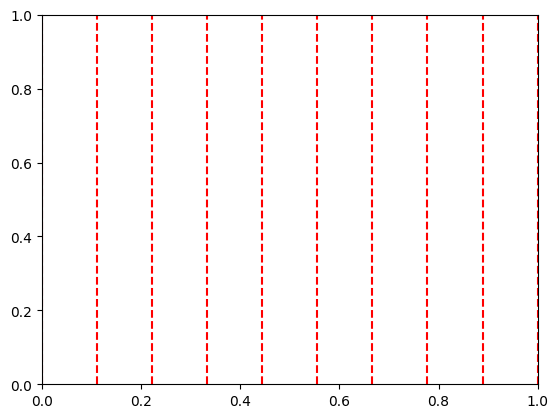

In [568]:
[plt.axvline(x, color="red", linestyle="--") for x in input_x]
plt.show()

In [569]:
step = 100
for i in range(step):
    best_x, _ = beta_greedy_search.forward(beta_greedy_search.beta_greedy_obj)
    beta_greedy_search.update(best_x, beta_greedy_search.f(best_x))

C:\Users\MSI-NB\AppData\Local\Temp\ipykernel_33752\2497904695.py:26: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(p2)


In [570]:
xgrid = np.linspace(0, 1, 1000)
ygrid = np.array([beta_greedy_search.f(x) for x in xgrid])

predictions = np.array([beta_greedy_search.interpolation_func(x) for x in xgrid])

np.sqrt(np.mean((ygrid - predictions) ** 2))

np.float64(0.0037425268999251174)

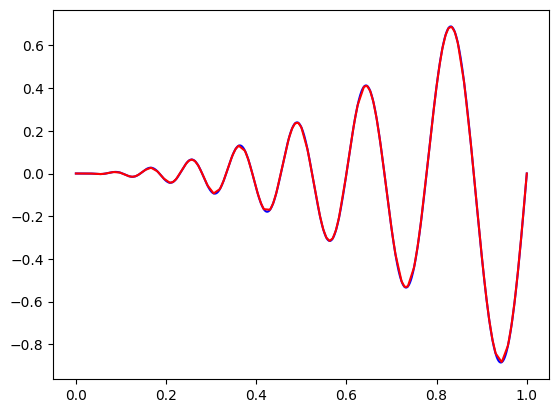

In [571]:
plt.plot(xgrid, ygrid, color="blue")

plt.plot(xgrid, predictions, color="red")
plt.show()

In [572]:
class ResidualSearch(BetaGreedySearch):
    def __init__(self, input_x, input_y, kernel=None, f=None, beta=0):
        super().__init__(input_x, input_y, kernel, f, beta)

    def residual_difference(self, x, lag=None):
        if lag is None:    
            lag = self.n // 2
        res_1 = self.interpolation_func(x)
        res_2 = self.interpolation_func(x, index=range(self.n - lag))

        # return np.abs(res_2 - res_1) 
        return np.abs(res_2 - res_1) + 1
    
    def residual_greedy_obj(self, x):
        # print(np.power(self.residual_difference(x, 1), self.beta), np.power(self.power_func(x), 1 - self.beta))

        # return -1 * np.power(self.power_func(x), 1 - self.beta) / np.power(self.residual_difference(x, 1), self.beta)
        return -1 * np.power(self.power_func(x), 1 - self.beta) * np.power(self.residual_difference(x), self.beta)
        # return 1 * np.power(self.residual_difference(x, 1), self.beta) - np.power(self.power_func(x), 1 - self.beta)
        # return self.beta * self.residual_difference(x, 1) - (1 - self.beta) * self.power_func(x)

In [573]:
residual_search = ResidualSearch(input_x, input_y, wendland_kernel, f, beta=0.5)

In [574]:
for i in range(step):
    best_x, _ = residual_search.forward(residual_search.residual_greedy_obj)
    residual_search.update(best_x, residual_search.f(best_x))

C:\Users\MSI-NB\AppData\Local\Temp\ipykernel_33752\2497904695.py:26: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(p2)


In [575]:
xgrid = np.linspace(0, 1, 1000)
ygrid = np.array([residual_search.f(x) for x in xgrid])

predictions = np.array([residual_search.interpolation_func(x) for x in xgrid])

np.sqrt(np.mean((ygrid - predictions) ** 2))

np.float64(0.0032809253049402793)

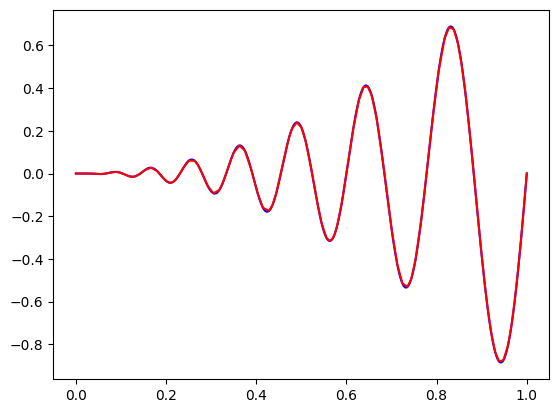

In [576]:
plt.plot(xgrid, ygrid, color="blue")

plt.plot(xgrid, predictions, color="red")
plt.show()

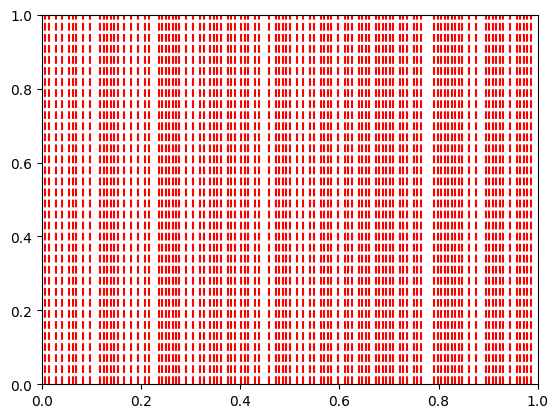

In [577]:
[plt.axvline(x, color="red", linestyle="--") for x in beta_greedy_search.points_set[n:]]
plt.show()

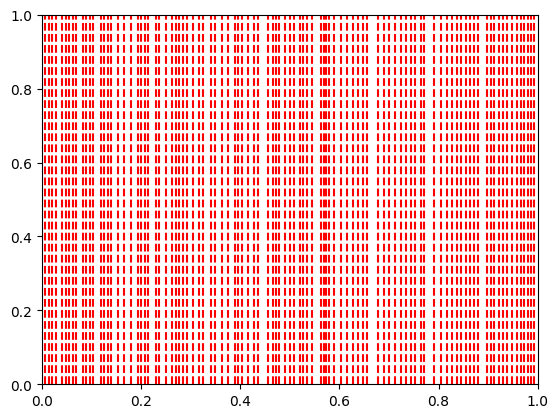

In [578]:
[plt.axvline(x, color="red", linestyle="--") for x in residual_search.points_set[n:]]
plt.show()

beta_1 = 0, beta_2 = 0.5.

1. step = 10, rmse_1 = 0.0832752311901809, rmse_2 = 0.07394168675110753.
2. step = 50, rmse_1 = 0.014231257001680592, rmse_2 = 0.01102695530611681.
3. step = 100, rmse_1 = 0.0037425268999251174, rmse_2 = 0.003672198644718923.
4. step = 200, rmse_1 = 0.0010707453919883035, rmse_2 = 0.0009504940375967213.